# Exercise

The cosmological growth factor describes the rate of growth of dark matter perturbations in the Universe and is defined as 

$D(a) = \large \frac{5 \Omega_m}{2} \frac{H(a)}{H_0} \int_0^a \frac{da'}{ (a' H(a')/H_0)^3}$,

where $a$ is the scale factor, $\Omega_m$ is the matter density parameter and $H(a)$ is the Hubble rate. In a flat Universe, after radiation domination, we can write $H(a)$ as:

$ E(a) = H(a)/H_0 = \sqrt{(\Omega_m a^{-3} + \Omega_{\Lambda})}$,

where $\Omega_\Lambda$ is the vacuum energy density (in a flat Universe, $\Omega_{\Lambda} = 1 - \Omega_m$).

1) Write a code to calculate the growth factor as a function of a, for given values of the cosmological parameters, using two numerical integration methods of your choice.

2) Plot the growth factor in the scale factor range $a \in [0.1,2]$ for the following values of $\Omega_m$: $0.1$, $0.3$, $0.6$, $1$ (assume a present day expansion rate $H_0 = 67.4 \, {\rm km} \, {\rm s}^{-1}\, {\rm Mpc}^{-1}$). Make a panel with two plots, one for each integration method you chose. Set logscale on x-axis.

3) Optional. For $a = 0.5$, compute the growth factor using the Simpson's rule with varying N and check the convergence rate of the result. Start by sampling the integration interval with ten points and then increase the sample size by a factor of $2$ at each step. How many steps do you need to achieve a final desired accuracy of $10^{-12}$ ?

4) Do cosmic structures grow faster in a matter dominated Universe, or in a Universe with a cosmological constant?

## Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate

## Functions

In [2]:
def E2 (a, Omega_m):
    Omega_L = 1. - Omega_m
    return Omega_m * a**-3 + Omega_L

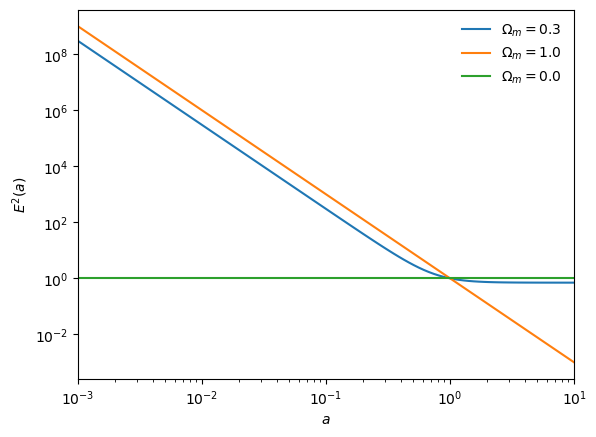

In [3]:
aas = np.logspace(-3, 1, 100)

plt.plot(aas, E2(aas, 0.3), label="$\Omega_m = 0.3$")
plt.plot(aas, E2(aas, 1.), label="$\Omega_m = 1.0$")
plt.plot(aas, E2(aas, 0.), label="$\Omega_m = 0.0$")

plt.xlabel("$a$")
plt.ylabel("$E^2(a)$")
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)

plt.loglog()
plt.show()

In [4]:
def growth_integrand(a, Omega_m):
    return (a **-3)* E2(a, Omega_m)**-1.5

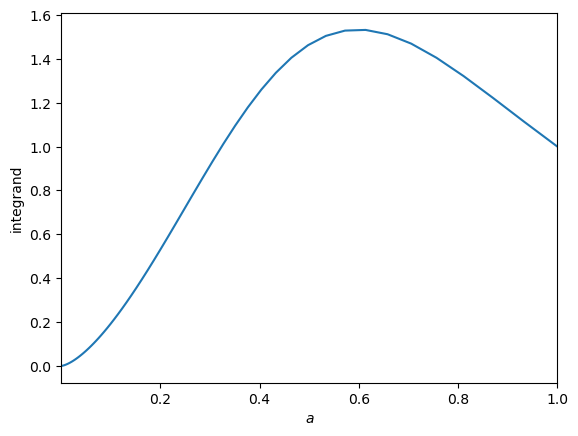

In [5]:
aas = np.logspace(-3, 0, 100)

plt.plot(aas, growth_integrand(aas, 0.3))

plt.xlabel("$a$")
plt.ylabel("integrand")
plt.xlim(aas[0], aas[-1])

plt.show()

## numpy.trapz

In [6]:
def growth_factor_trpz(a, Omega_m, sampling_points=100): 
    aas = np.linspace(1.e-9, a, sampling_points)
    
    # In order to vectorize the calculation later,
    # we have to specify the axis on which to perform the integration.
    # Otherwise, this leads to a lot of head-scratching during the tutorial!
    integral = np.trapz(growth_integrand(aas, Omega_m), x=aas, axis=0)
    
    return 5./2. * Omega_m * np.sqrt(E2(a, Omega_m)) * integral

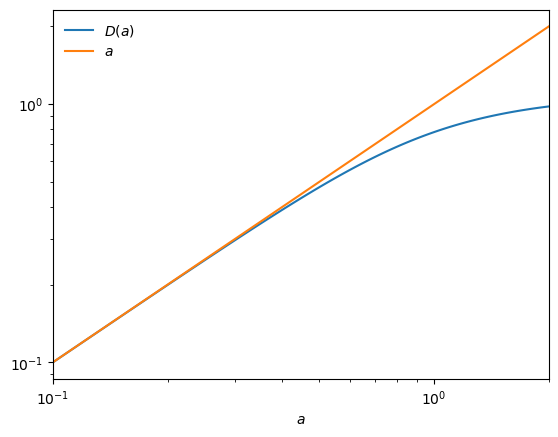

In [7]:
aas = np.linspace(1.e-1, 2., 100)
plt.plot(aas, growth_factor_trpz(aas, 0.3), label="$D(a)$")
plt.plot(aas, aas, label="$a$")

plt.loglog()
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)
plt.xlabel("$a$")
#plt.ylabel("Growth factor")

plt.show()

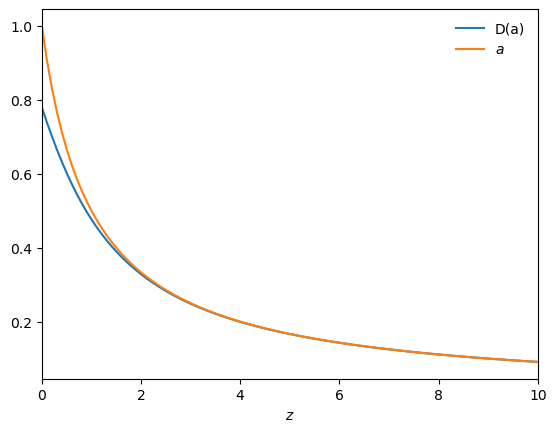

In [8]:
zs = np.linspace(0, 10., 100)
plt.plot(zs, growth_factor_trpz((zs+1)**-1, 0.3), label="D(a)")
plt.plot(zs, (zs+1)**-1, label="$a$")

plt.xlim(zs[0], zs[-1])
plt.legend(frameon=False)
plt.xlabel("$z$")

plt.show()

/tmp/ipykernel_2615/3474320013.py:2: RuntimeWarning: divide by zero encountered in power
  return (a **-3)* E2(a, Omega_m)**-1.5
/tmp/ipykernel_2615/1496804094.py:3: RuntimeWarning: divide by zero encountered in power
  return Omega_m * a**-3 + Omega_L
/tmp/ipykernel_2615/3474320013.py:2: RuntimeWarning: invalid value encountered in multiply
  return (a **-3)* E2(a, Omega_m)**-1.5


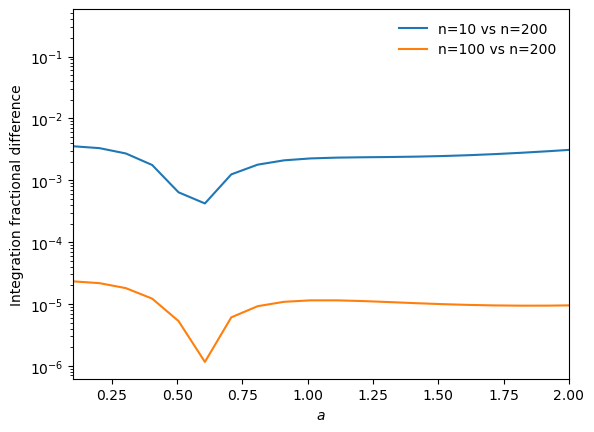

In [9]:
def residuals(aas, Omega_m, n1, n2):
    integ_n1 = growth_factor_trpz(aas, Omega_m, sampling_points=n1)
    integ_n2 = growth_factor_trpz(aas, Omega_m, sampling_points=n2)
    
    return np.abs(integ_n1 - integ_n2)/integ_n2

aas = np.linspace(1.e-1, 2., 100)

plt.plot(zs, residuals(zs, 0.3, 10, 200), label="n=10 vs n=200")
plt.plot(zs, residuals(zs, 0.3, 100, 200), label="n=100 vs n=200")

plt.semilogy()
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)
plt.xlabel("$a$")
plt.ylabel("Integration fractional difference")

plt.show()

## scipy.integrate.romberg

In [10]:
def growth_factor_romb(a, Omega_m):
    integral = scipy.integrate.romberg(
        growth_integrand, 
        1.e-6, a, 
        rtol=1.e-3,
        args=(Omega_m,)) 
    return 5./2. * Omega_m * np.sqrt(E2(a, Omega_m)) * integral

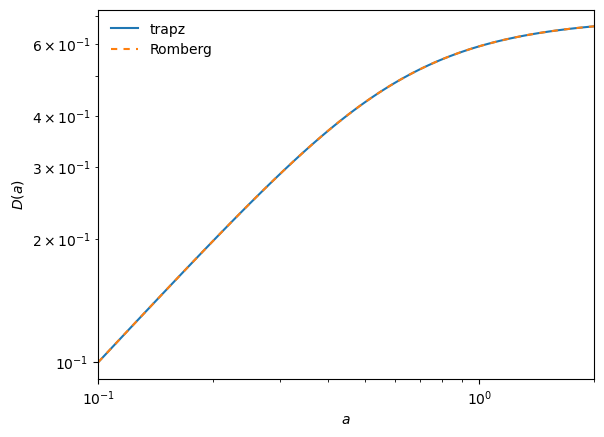

In [11]:
aas = np.logspace(-1, np.log10(2), 100)

plt.plot(aas, growth_factor_trpz(aas, .1), label = "trapz")
plt.plot(aas, [growth_factor_romb(a, .1) for a in aas], label = "Romberg", dashes=[3,3])

plt.loglog()
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)
plt.xlabel("$a$")
plt.ylabel("$D(a)$")

plt.show()

## Simpson 1/3

In [12]:
def integrate_S13(f, a, b, tol, *args, dbg=False):
    """Simpson 1/3 integrator with error management via recursive subdivisions.
    
    Arguments:
    f : callable
        Integrand function. Must accept the integration variable as first argument
        and return its value. Additional arguments can be specified as *args
    a : float
        Integral lower bound.
    b : float
        Integral upper bound.
    tol : float
        Desired relative tolerance.
    dbg : bool
        Prints additional information about the execution
    """
    n = 2
    
    fafb = f(a, *args) + f(b, *args)
    i_n = f((b-a)/2., *args)
    I_2n = (fafb + 4.*i_n) * (b-a)/n /3.
    
    I_n = I_2n * (1+10.*tol)
    
    enum = 0
    
    while(np.fabs(I_n/I_2n-1.) > tol):
        I_n = I_2n
        n = 2*n
        
        # get the new sampling points
        xs = np.linspace(a, b, n+1)
    
        # Calculate the function on the new even sampling points.
        # the odd coincide with the ones calculated in all the previous steps.
        # All the values of the function evaluated on the even points are summed.
        i_2n = np.sum(f(xs[1::2], *args))
        
        # f(a) and f(b) appear without any coeffiecient,
        # f(even points) = the one calculated in this cycle gets multiplied by 4
        # f(odd points) = the ones calculated before gets multipled by 2
        I_2n = (fafb + 4.*i_2n + 2.*i_n) * (b-a)/n /3.
        
        # the new points (even in this cycle) and the old points (odd in this cycle)
        # will all be odd in the next cycle
        i_n += i_2n
        enum += 1
        
    if(dbg):
        print("enum = ", enum)
        print("number of function evaluations = ", n+1)
    return I_2n

In [13]:
def growth_factor_S13(a, Omega_m):
    integral = integrate_S13(
        growth_integrand, 
        1.e-6, a, 
        1.e-3,
        Omega_m) 
    return 5./2. * Omega_m * np.sqrt(E2(a, Omega_m)) * integral

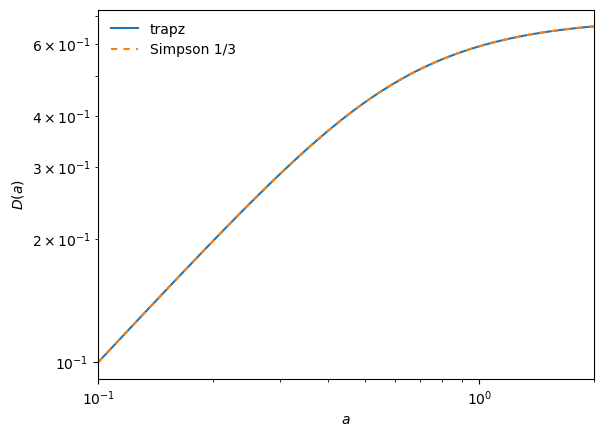

In [14]:
aas = np.logspace(-1, np.log10(2), 100)

plt.plot(aas, growth_factor_trpz(aas, .1), label="trapz")
plt.plot(aas, [growth_factor_S13(a, .1) for a in aas], label="Simpson 1/3", dashes=[3,3])

plt.loglog()
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)
plt.xlabel("$a$")
plt.ylabel("$D(a)$")

plt.show()

In [15]:
# We can automatically vectorize the function,
# to avoid using the list comprehension
growth_factor_S13 = np.vectorize(growth_factor_S13)

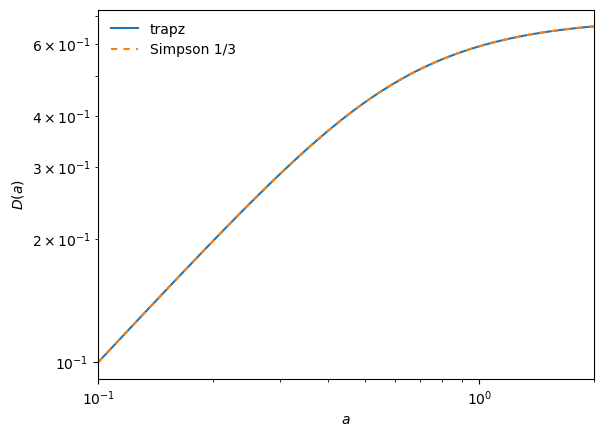

In [16]:
aas = np.logspace(-1, np.log10(2), 100)

plt.plot(aas, growth_factor_trpz(aas, .1), label="trapz")
plt.plot(aas, growth_factor_S13(aas, .1), label="Simpson 1/3", dashes=[3,3])

plt.loglog()
plt.xlim(aas[0], aas[-1])
plt.legend(frameon=False)
plt.xlabel("$a$")
plt.ylabel("$D(a)$")

plt.show()

## Assignment 2

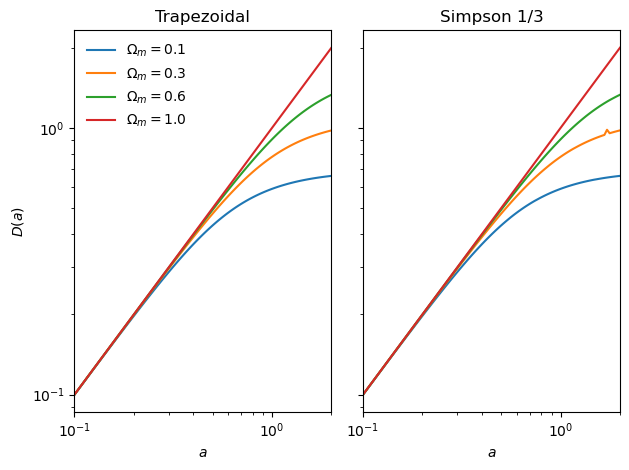

In [17]:
aas = np.logspace(-1, np.log10(2), 100)

fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

for omega in [.1, .3, .6, 1.]:
    axs[0].plot(aas, growth_factor_trpz(aas, omega), label="$\Omega_m = %.1f$" %omega)
    axs[1].plot(aas, growth_factor_S13(aas, omega))

axs[0].loglog()
axs[0].set_xlim(aas[0], aas[-1])
axs[0].legend(frameon=False)
axs[0].set_xlabel("$a$")
axs[1].set_xlabel("$a$")
axs[0].set_ylabel("$D(a)$")

axs[0].set_title('Trapezoidal')
axs[1].set_title('Simpson 1/3')

fig.tight_layout()

plt.show()

## Assignment 3

In [18]:
relative_tol = 1.e-12

integrate_S13(
        growth_integrand, 
        1.e-6, 0.5, 
        relative_tol,
        0.3,
        dbg=True) 

enum =  21
number of function evaluations =  4194305


0.3609095056886648

## Numerical stability

The integrand can be simplified to avoid apparent singularities

In [19]:
def growth_integrand_2(a, Omega_m):
    Omega_L = 1. - Omega_m
    return (Omega_m + Omega_L*a**3)**-1.5 * a**1.5

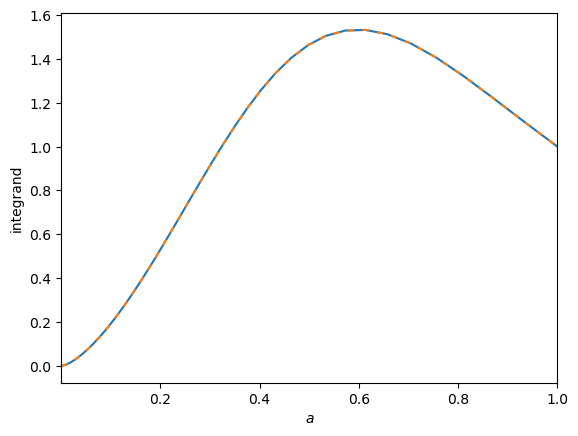

In [20]:
aas = np.logspace(-3, 0, 100)

plt.plot(aas, growth_integrand(aas, 0.3))
plt.plot(aas, growth_integrand_2(aas, 0.3), dashes=[3,4])

plt.xlabel("$a$")
plt.ylabel("integrand")
plt.xlim(aas[0], aas[-1])

plt.show()

In [21]:
relative_tol = 1.e-12

integrate_S13(
        growth_integrand_2, 
        0, 0.5, 
        relative_tol,
        0.3,
        dbg=True) 

enum =  15
number of function evaluations =  65537


0.36090950568898855